In [2]:
from IPython.display import clear_output, display
import warnings

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from PIL import Image
import seaborn as sns
import torch
from ipywidgets import Dropdown, FloatSlider, HBox, VBox

from era_data import TabletPeriodDataset, get_IDS
from VAE_model_tablets_class import VAE
from visualization_funcs import generate_image_from_VAE

warnings.filterwarnings("ignore", category=FutureWarning)

# Hyperparameters

In [3]:
IMG_DIR = 'output/images_preprocessed'
BATCH_SIZE = 16
VERSION_NAME = 'period_clf_bs16_lr5e-05_beta_1_epochs_30-VAE-94936_samples-masked_w_classification_loss-equalpartsloss-March29'
IDS = get_IDS(IMG_DIR=IMG_DIR)
print(len(IDS))

94936


In [4]:
num_classes = len(TabletPeriodDataset.PERIOD_INDICES)
class_weights = torch.load("data/class_weights_period.pt")

In [8]:
df_encodings_train = pd.read_csv(f'vae_encodings_and_data/vae_encoding_df_March30_w_class_train.csv')
df_encodings_test = pd.read_csv(f'vae_encodings_and_data/vae_encoding_df_March30_w_class_test.csv')

# Load Model

In [6]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'

In [7]:
checkpoint_path = f'lightning_logs/{VERSION_NAME}/checkpoints/epoch=29-step=170458.ckpt'
vae_model = VAE.load_from_checkpoint(checkpoint_path,image_channels=1,z_dim=12, lr =5e-5, use_classification_loss=True, num_classes=num_classes,
            loss_type="weighted", class_weights=class_weights, device = device)

/sise/mickyfi-group/kapond/AnalysisBySynthesis/VAE_model_tablets_class.py:75: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  self.class_weights = torch.tensor(class_weights).to(device)


# Plot entries boxplots

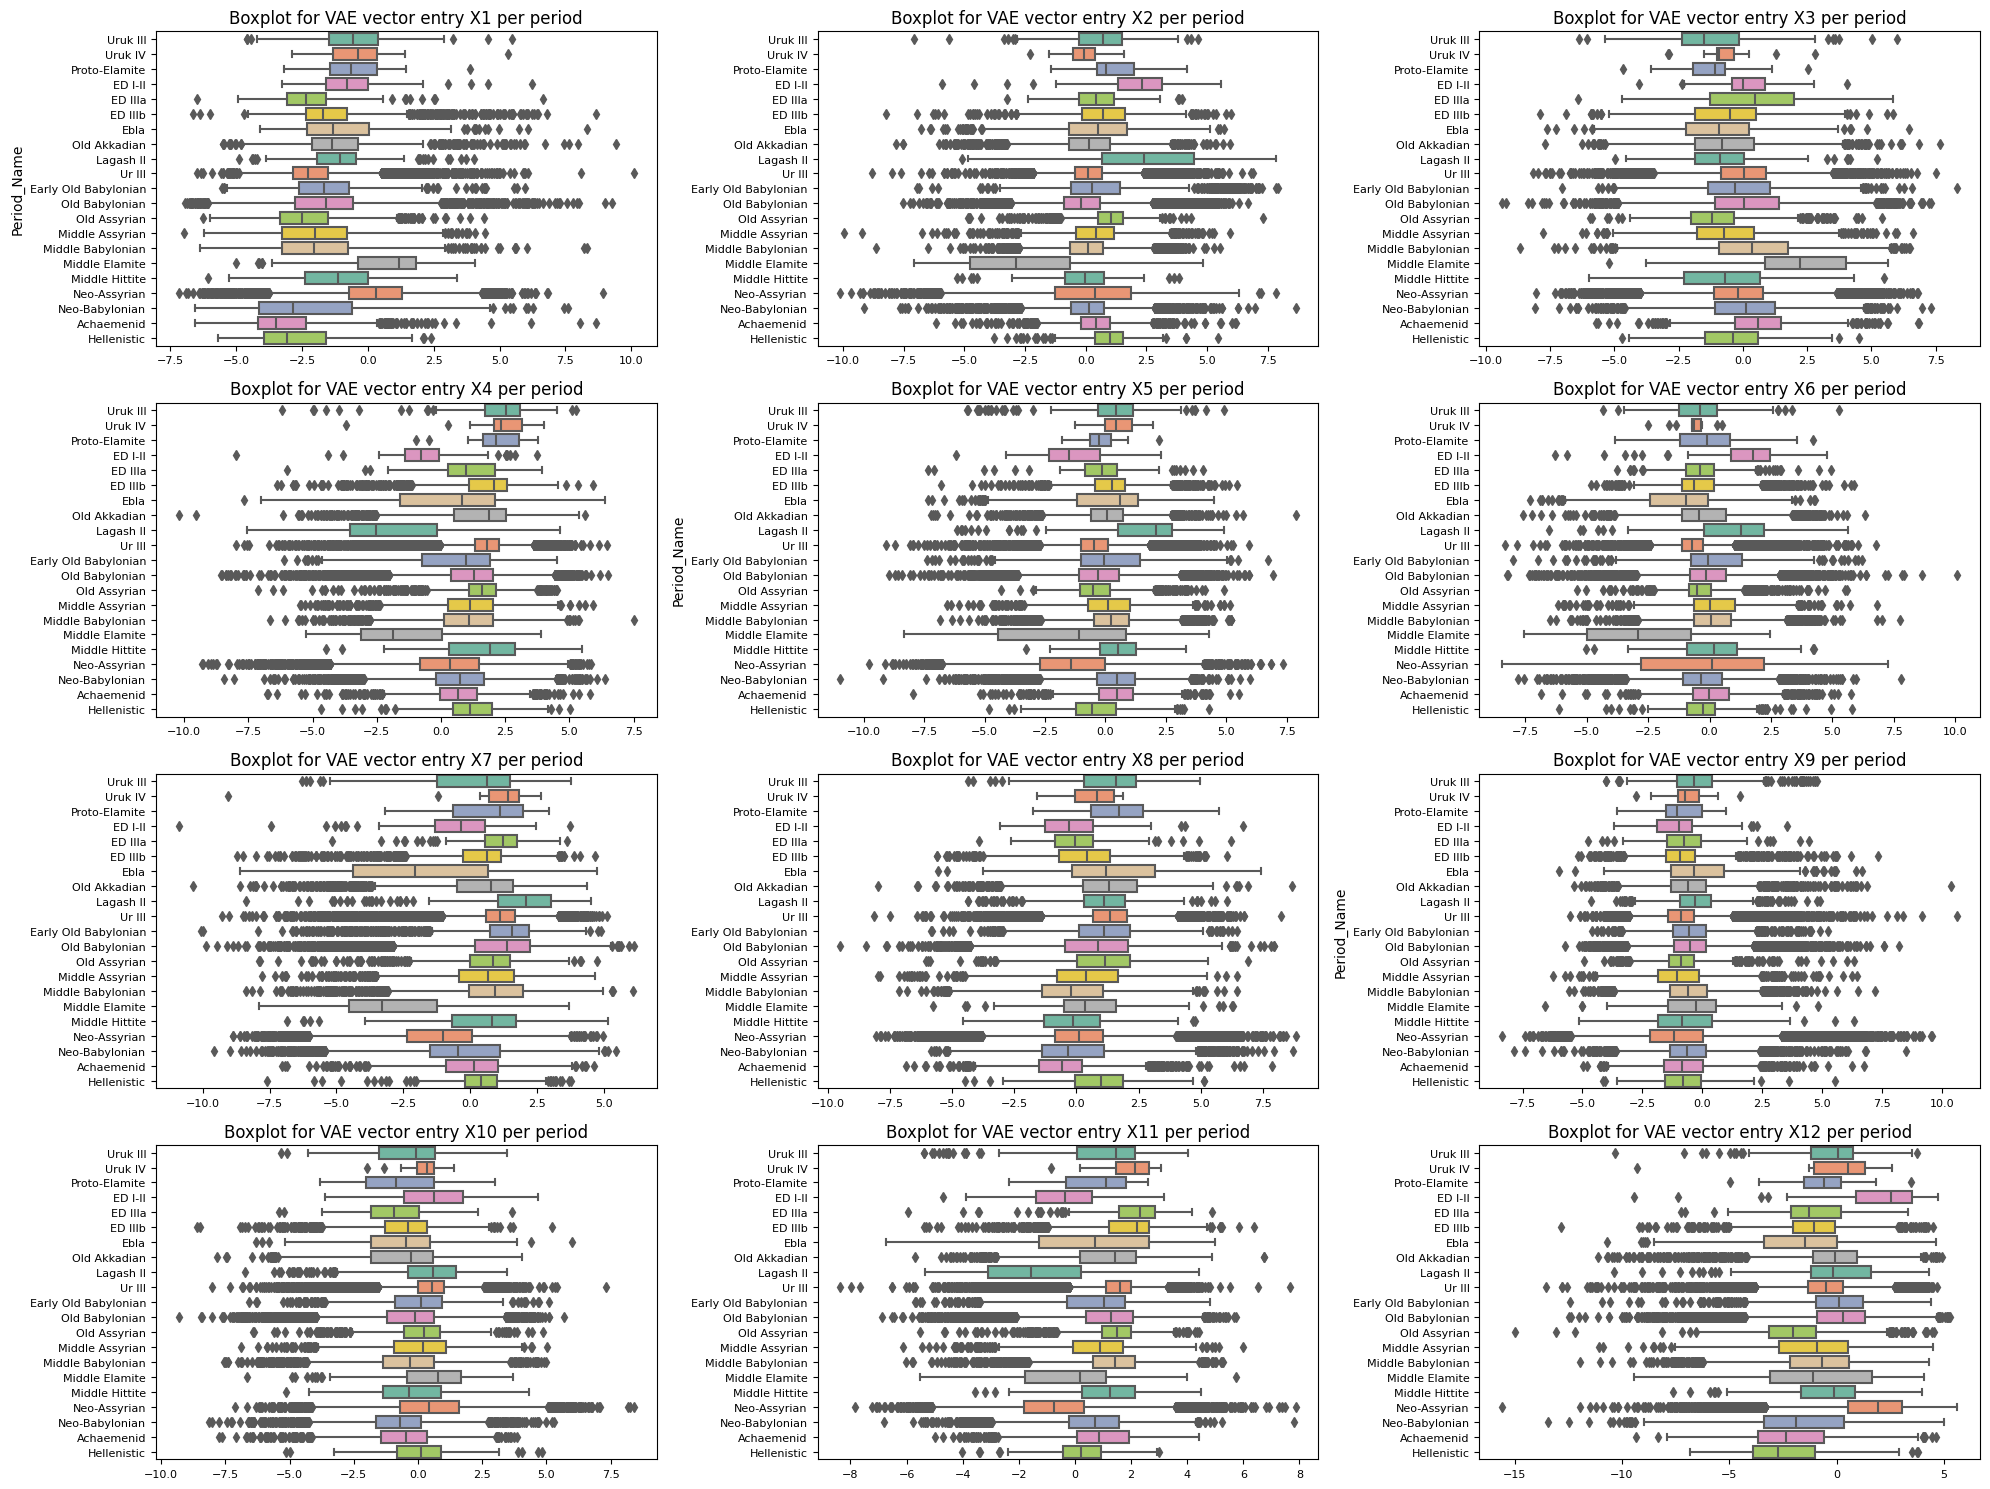

In [11]:
period_order = ['Uruk III', 'Uruk IV', 'Proto-Elamite', 'ED I-II', 'ED IIIa', 'ED IIIb', 'Ebla', 'Old Akkadian', 'Lagash II', 
                'Ur III', 'Early Old Babylonian', 'Old Babylonian', 'Old Assyrian', 'Middle Assyrian', 
                'Middle Babylonian', 'Middle Elamite', 'Middle Hittite', 'Neo-Assyrian', 
                'Neo-Babylonian', 'Achaemenid', 'Hellenistic']

palette = 'Set2'  
fig, axes = plt.subplots(nrows=4, ncols=3, figsize=(20, 15))  # Adjust figsize as needed
axes = axes.flatten()  

for i, col in enumerate([f'X{i}' for i in range(1, 13)]):
    sns.boxplot(x=col, y='Period_Name', data=df_encodings_train, order=period_order, ax=axes[i], palette=palette)
    axes[i].set_title(f'Boxplot for VAE vector entry {col} per period')
    axes[i].tick_params(labelsize=8)  # Adjust label size for better readability
    if i < 12:  
        axes[i].set_xlabel('')
    if i % 4 != 0: 
        axes[i].set_ylabel('')

plt.tight_layout()  
plt.show()

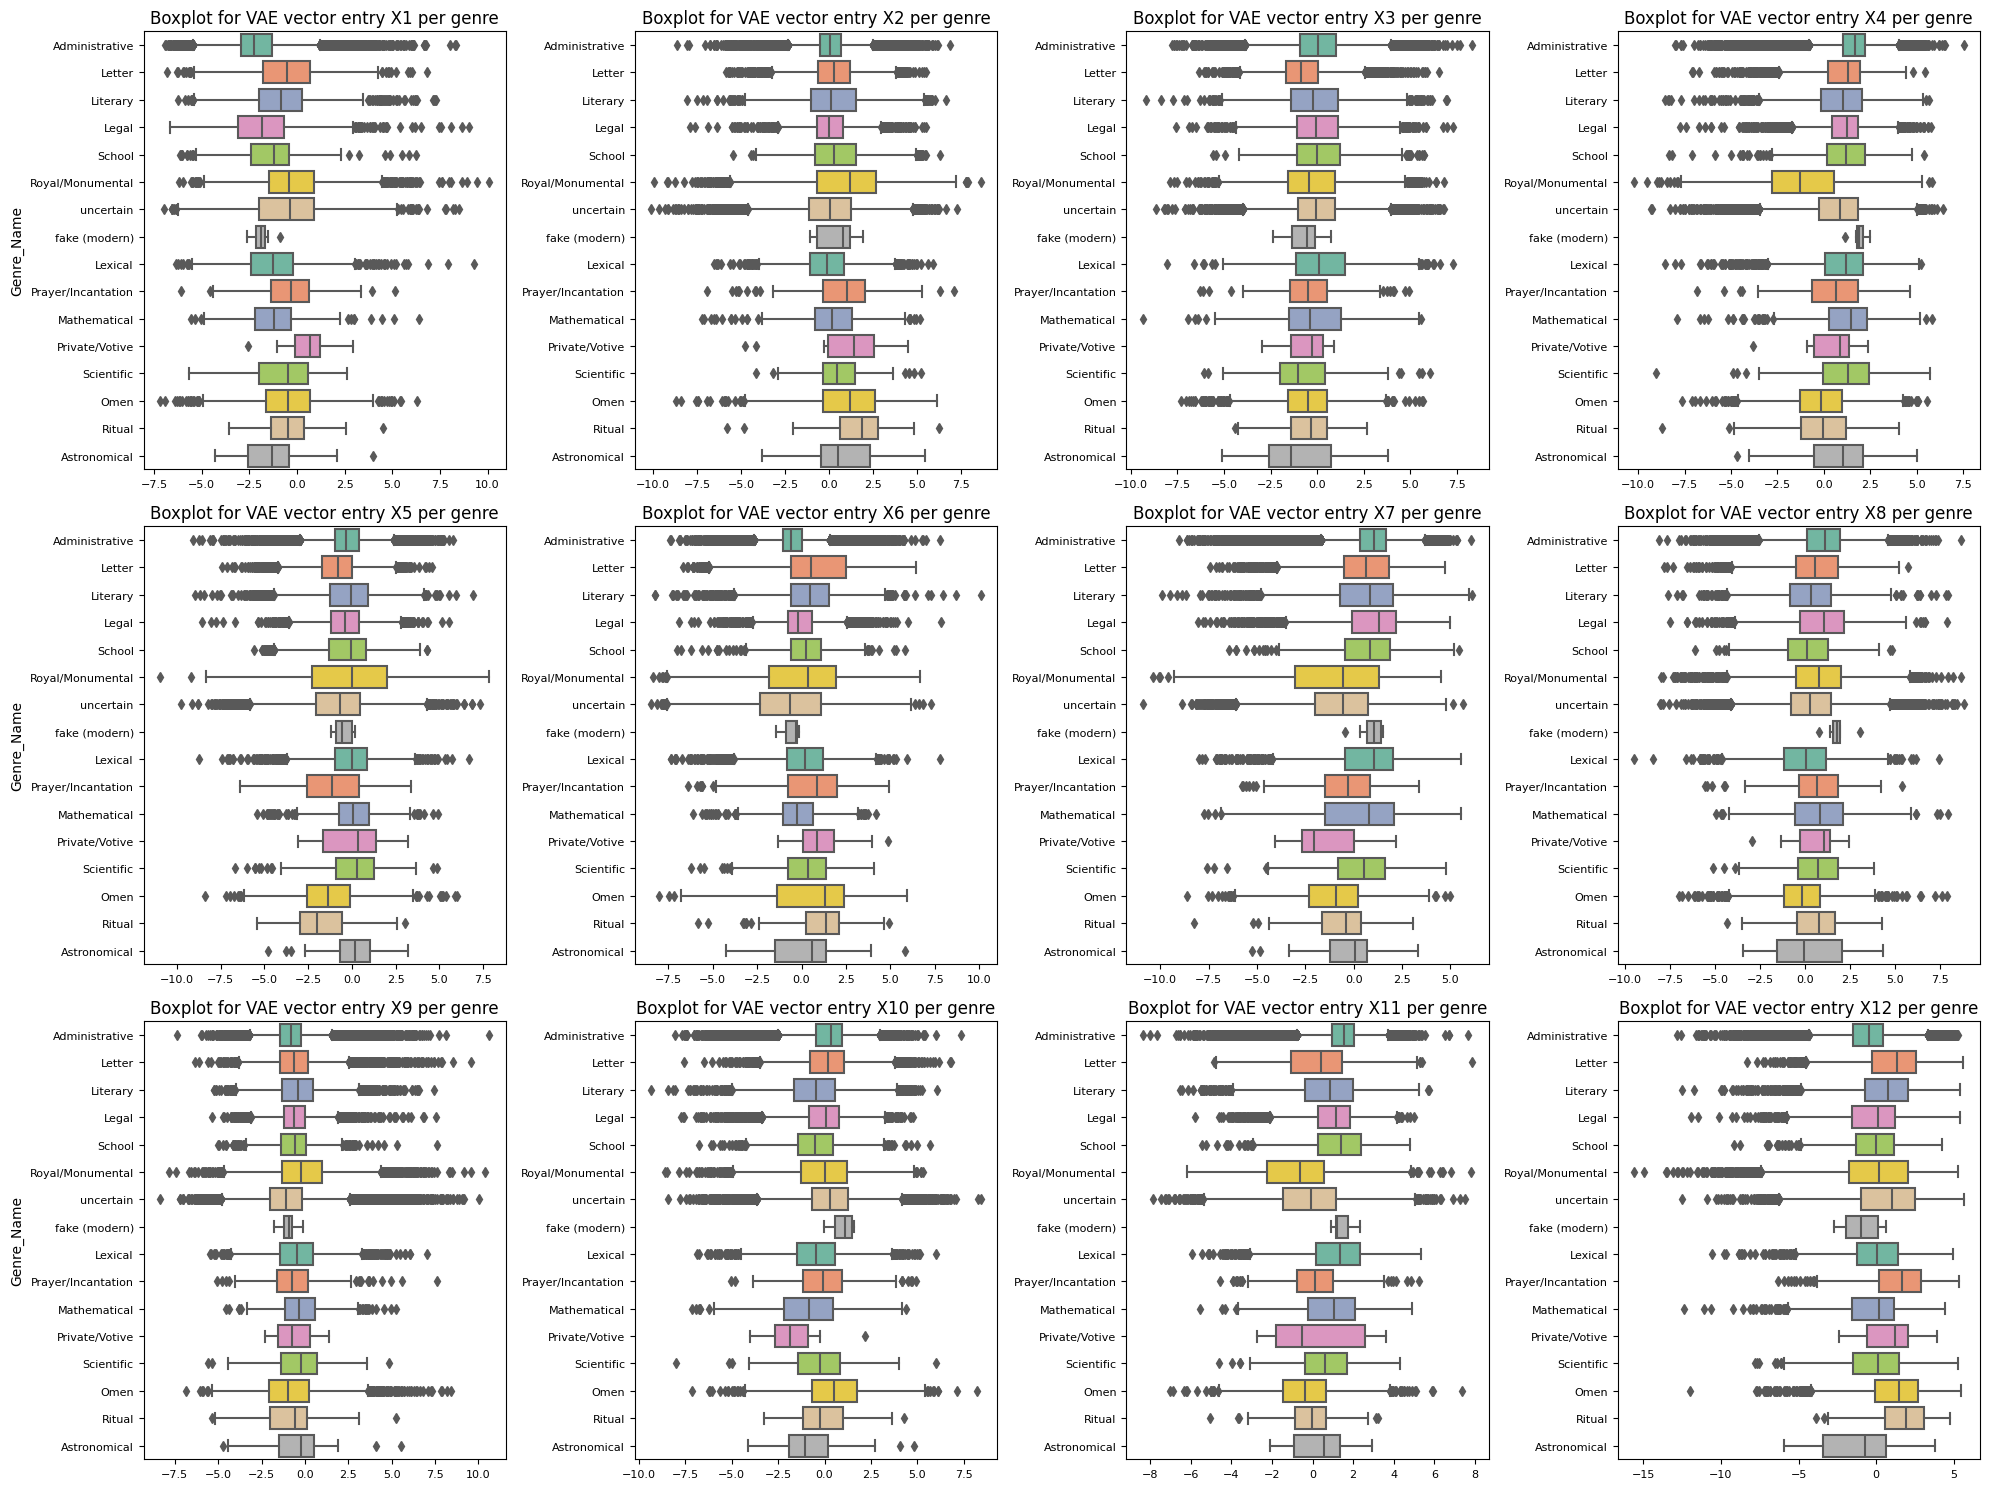

In [14]:
fig, axes = plt.subplots(nrows=3, ncols=4, figsize=(20, 15)) 
axes = axes.flatten()  

for i, col in enumerate([f'X{i}' for i in range(1, 13)]):
    sns.boxplot(x=col, y='Genre_Name', data=df_encodings_train, ax=axes[i], palette=palette)
    axes[i].set_title(f'Boxplot for VAE vector entry {col} per genre')
    axes[i].tick_params(labelsize=8) 
    if i < 12:  
        axes[i].set_xlabel('')
    if i % 4 != 0: 
        axes[i].set_ylabel('')

plt.tight_layout()  
plt.show()

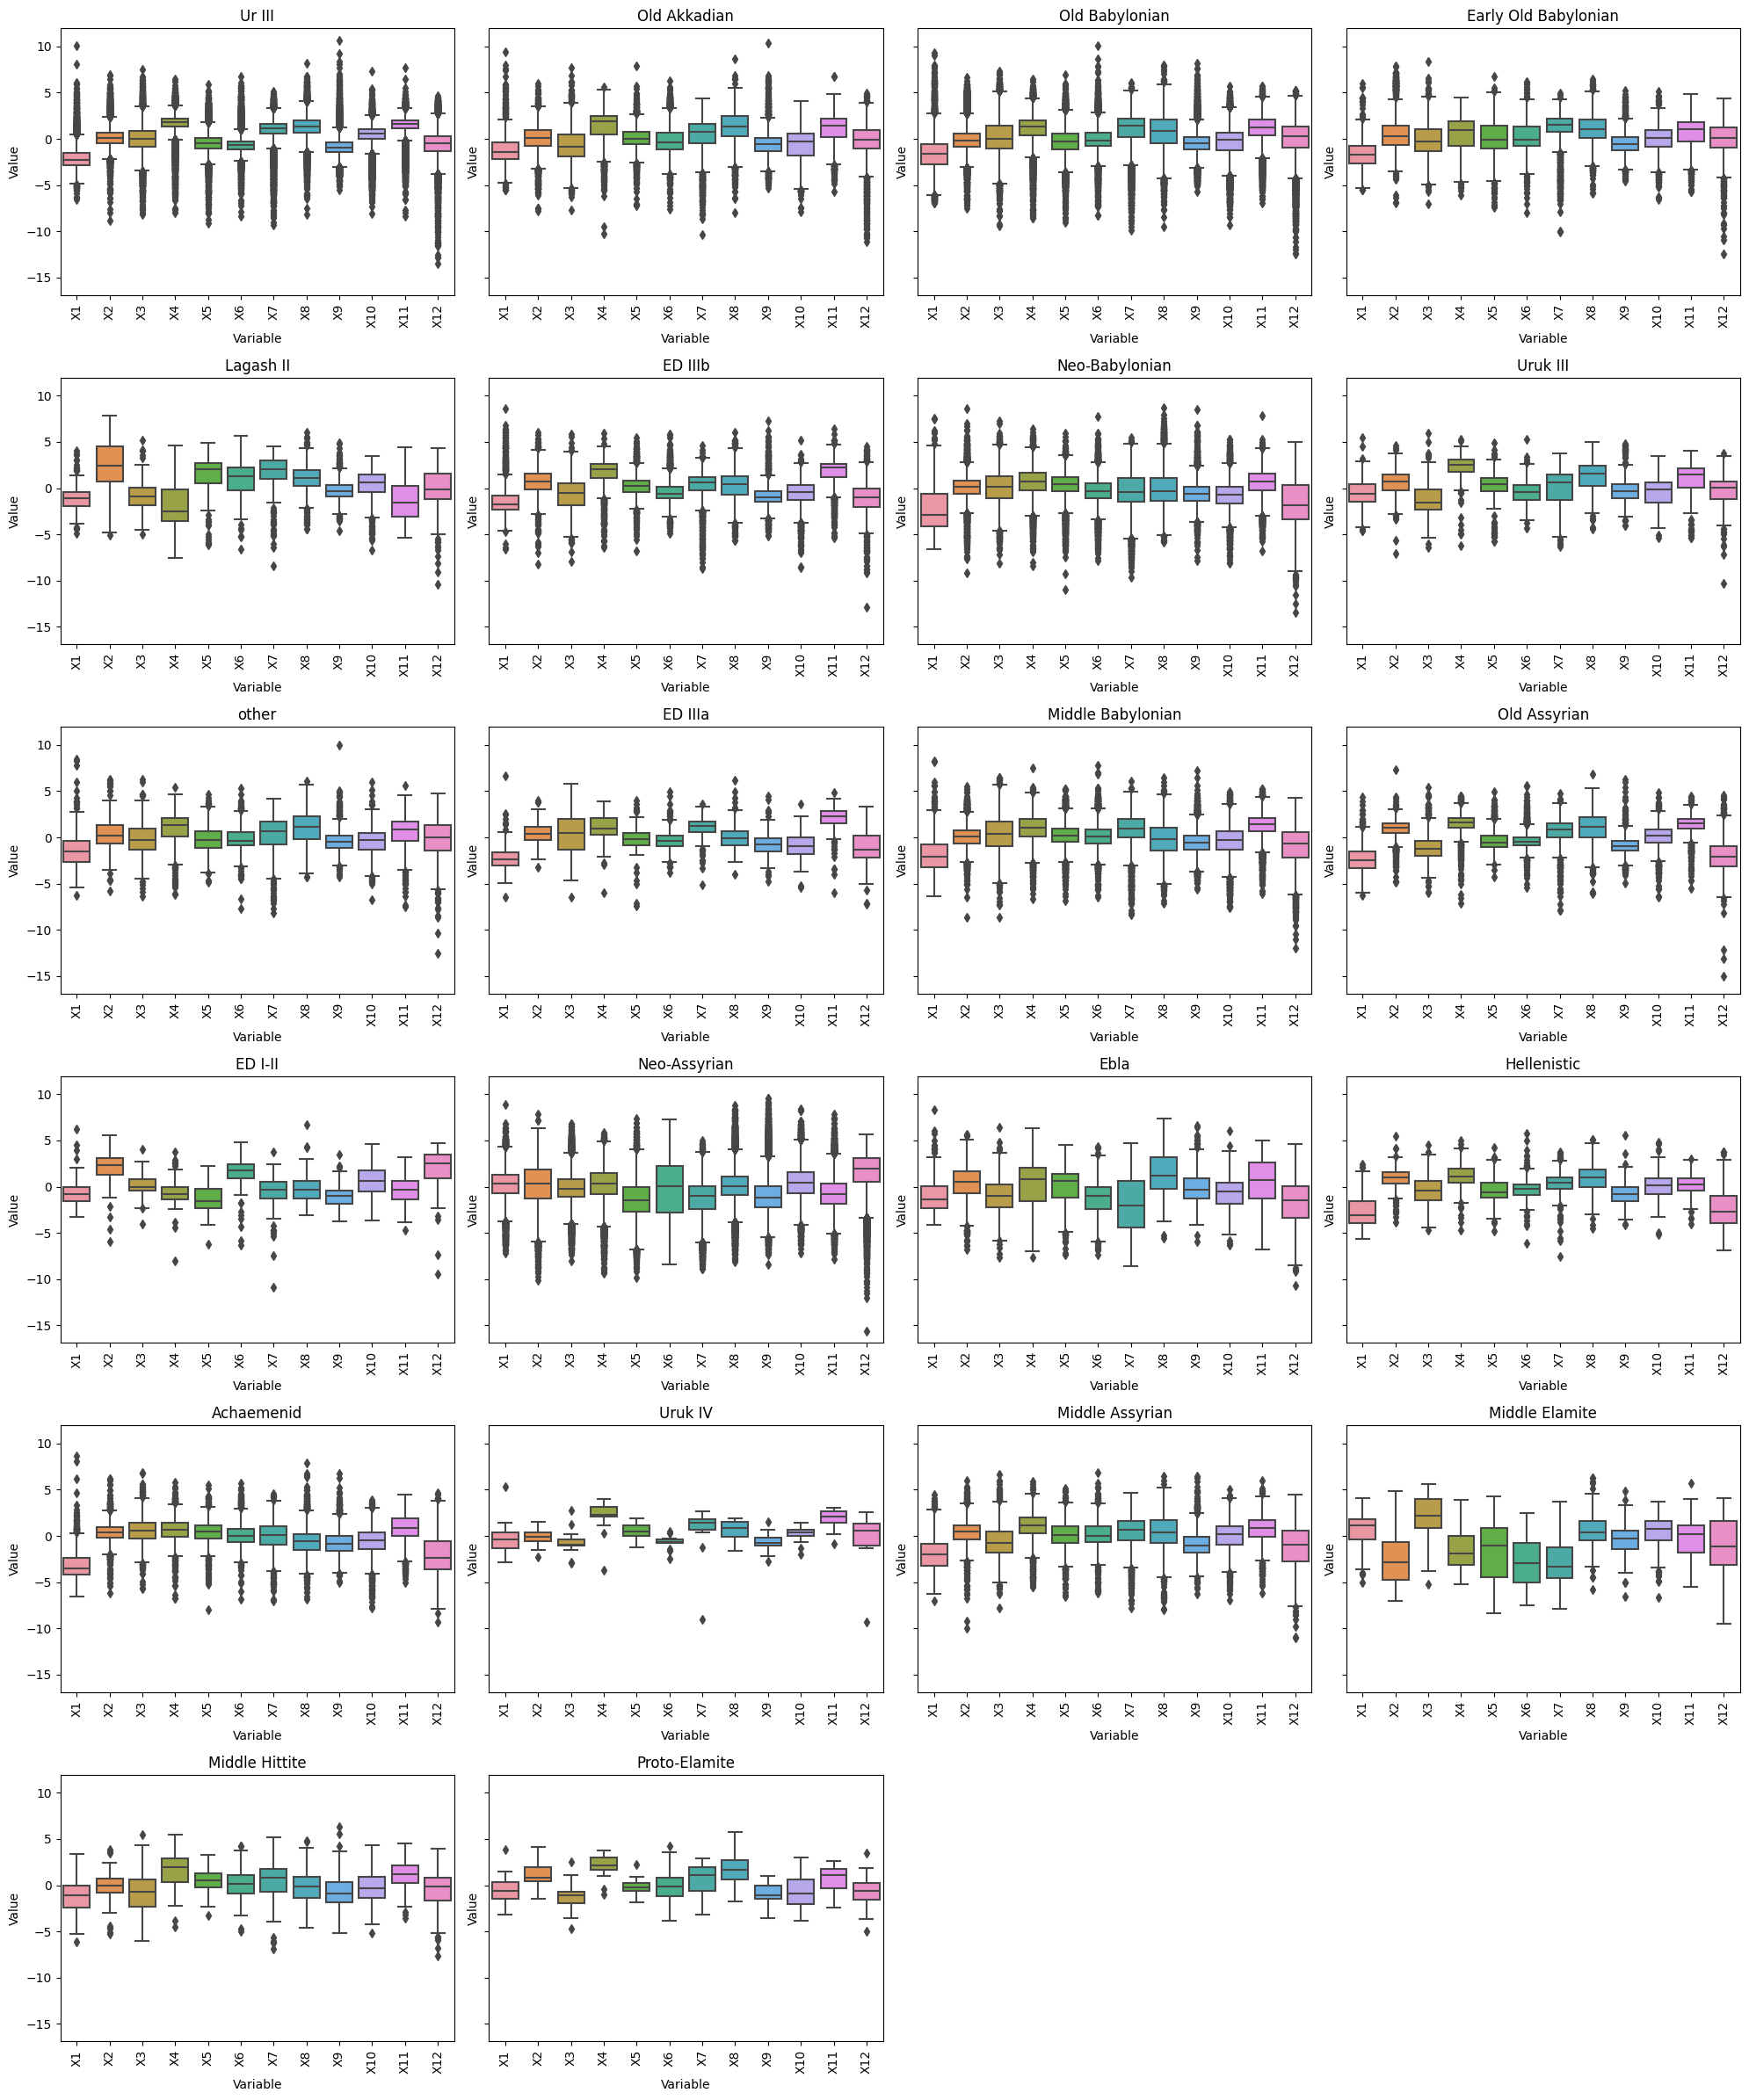

In [15]:
melted_df = df_encodings_train.melt(id_vars='Period_Name', value_vars=[f'X{i}' for i in range(1, 13)],
                                    var_name='Variable', value_name='Value')

n_cols = 4
n_rows = -(-22 // n_cols)

fig, axes = plt.subplots(nrows=n_rows, ncols=n_cols, figsize=(20, 4*n_rows), sharey=True) 
axes = axes.flatten()  

for i, period in enumerate(melted_df['Period_Name'].unique()):
    sns.boxplot(x='Variable', y='Value', data=melted_df[melted_df['Period_Name'] == period], ax=axes[i])
    axes[i].set_title(period)
    axes[i].tick_params(axis='x', rotation=90)  
    
for j in range(i+1, len(axes)):
    axes[j].set_visible(False)

plt.tight_layout()
plt.show()


# Widget for understanding the meaning of each entry

In [26]:
def generate_image(*args):
    vector = np.array([slider.value for slider in sliders])
    
    if len(vector) == 0:  # Checks if there's no data (vector is empty)
        with out:
            clear_output(wait=True)
            display(Image.new('RGB', (128, 128), color = 'white'))  # Display a blank/white image
    else:
        out.clear_output(wait=True)
    
        vector = np.array([slider.value for slider in sliders])
        generated_image_tensor = generate_image_from_VAE(vector, vae_model)   
        generated_image_np = (generated_image_tensor.numpy() * 255).astype(np.uint8)
        
        # Resize the image here. Adjust (64, 64) to your desired dimensions.
        image = Image.fromarray(generated_image_np).resize((180, 180))
        
        with out:
            display(image)

In [27]:
period_options = ['None'] + sorted(df_encodings_train['Period_Name'].unique().tolist())
period_dropdown = Dropdown(options=period_options, value='None', description='Period:')

genre_options = ['None'] + sorted(df_encodings_train['Genre_Name'].unique().tolist())
genre_dropdown = Dropdown(options=genre_options, value='None', description='Genre:')

sliders = []
sliders_container = HBox(children=[])

out = Output()

def update_output(*args):
    period = period_dropdown.value if period_dropdown.value != 'None' else None
    genre = genre_dropdown.value if genre_dropdown.value != 'None' else None
    
    imgs_to_disp_df = df_encodings_train.drop(['Genre', 'Period', 'CDLI_id'], axis=1).copy()
    
    if period:
        imgs_to_disp_df = imgs_to_disp_df[imgs_to_disp_df['Period_Name'] == period]
    
    if genre:
        imgs_to_disp_df = imgs_to_disp_df[imgs_to_disp_df['Genre_Name'] == genre]

    if not imgs_to_disp_df.empty:
        sliders.clear()  # Clear existing slider list
        initial_vector = imgs_to_disp_df.sample().drop(['Genre_Name', 'Period_Name'], axis=1).iloc[0].values.astype('float32')
        
        for i, val in enumerate(initial_vector):
            slider = FloatSlider(value=val, min=-3, max=3, step=0.01, description=f'Entry {i+1}')
            slider.observe(generate_image, 'value')
            sliders.append(slider)
        
        midpoint = len(sliders) // 2
        left_column = VBox(sliders[:midpoint])
        right_column = VBox(sliders[midpoint:])
        
        sliders_container.children = [left_column, right_column]
    else:
        sliders.clear()
        sliders_container.children = []  # Clear the display of existing sliders
        generate_image() 

period_dropdown.observe(update_output, 'value')
genre_dropdown.observe(update_output, 'value')

layout_container = HBox([sliders_container, out])

display(period_dropdown, genre_dropdown, layout_container)

update_output()


Dropdown(description='Period:', options=('None', 'Achaemenid', 'ED I-II', 'ED IIIa', 'ED IIIb', 'Early Old Bab…

Dropdown(description='Genre:', options=('None', 'Administrative', 'Astronomical', 'Legal', 'Letter', 'Lexical'…

Conclusions?

* Entry 1: how wide the tablet is + number of angles shown / rectangular vs round?
* Entry 2: is the image placed to the left or not / how big is the centerpiece + thickness of tablet
* Entry 3: gap between the angles + is the shape more square?
* Entry 4: is the bottom left of the tablet is chipped, and how much + thickness
* Entry 5:  is the top left of the tablet is chipped, and how much + narrow side views
* Entry 6: how round the tablet is / smaller side centerpiece?
* Entry 7: if the picture is taken so that one of the sides is placed on top, or not
* Entry 8: how round is the tablet 
* Entry 9: is the tablet places on the left / right + how narrow the tablet is (is there some shadow ion the right?)
* Entry 10: is it one piece showing, or all angles
* Entry 11: are there many many displays, or just the 6 sides (e.g. cylinder or multiple fragments) 
* Entry 12: not so clear - seems like related to the number of fragments / how short the tablet is
* Entry 13: not so clear - seems like related to the number of fragments / how wide the tablet is (is there some shadow ion the left?)
* Entry 14: not so clear - seems like related to the number of fragments / bottom right of centerpience chipped
* Entry 15: not so clear - seems like related to the number of fragments
* Entry 16: upper/lower triangle